## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
from pandas.tseries.offsets import CustomBusinessDay
from pandas.tseries.holiday import USFederalHolidayCalendar
import os

## Parameters

In [2]:
def calculate_lookback_date(ticker, target_date_str, lookback_days=22):
    """
    Routes the date calculation based on asset class to ensure 
    lookback periods align with actual trading days.
    """
    target_date = pd.to_datetime(target_date_str)
    
    # Catches explicit crypto tickers or yfinance '-USD' suffixes
    crypto_identifiers = ['BTC', 'ETH', 'SOL', '-USD']
    is_crypto = any(crypto in ticker.upper() for crypto in crypto_identifiers)
    
    # Route the logic
    if is_crypto:
        # Crypto trades 24/7/365. Subtract standard calendar days.
        start_date_init = target_date - timedelta(days=lookback_days)
        asset_class = "Crypto"
        
    else:
        # Equities trade on business days. Skip weekends and US holidays.
        us_trading_days = CustomBusinessDay(calendar=USFederalHolidayCalendar())
        start_date_init = target_date - (lookback_days * us_trading_days)
        asset_class = "Equity"
        
    return start_date_init, asset_class

In [ ]:
def store_data(data_df, stage_process, ticker, interval):
    """Upserts new data into the master parquet file."""
    data_dir = f"../../data/{stage_process}/{ticker}/{interval}"
    data_path = f"{data_dir}/data.parquet"
    
    os.makedirs(data_dir, exist_ok=True)

    if os.path.exists(data_path):
        existing_df = pd.read_parquet(data_path, engine='pyarrow')
        combined_df = pd.concat([existing_df, data_df])
        combined_df = combined_df.drop_duplicates(subset=['Date'], keep='last')
        combined_df = combined_df.sort_values(by='Date')
        combined_df.to_parquet(data_path, index=False, engine='pyarrow')
        print(f"[{ticker}] Appended data. Master file total rows: {len(combined_df)}")
    else:
        data_df.sort_index().to_parquet(data_path, index=False, engine='pyarrow')
        print(f"[{ticker}] Created new master file at: {data_path}")

In [14]:
assets = ["NVDA"]
target_date_string = "2025-12-01"
interval = "daily"
lookback_days = 22
stage_process = "raw"


for ticker in assets:
    # Get the correctly calculated start date and the asset class
    start_date_init, asset_class = calculate_lookback_date(ticker, target_date_string, lookback_days)
    
    print(f"[{asset_class}] {ticker}: Target Date {target_date_string} -> Pulling data from {start_date_init.strftime('%Y-%m-%d')}")



[Equity] NVDA: Target Date 2025-12-01 -> Pulling data from 2025-10-28


## Pull Data In

In [15]:
asset_df = yf.download(ticker, start_date_init, auto_adjust=False)

[*********************100%***********************]  1 of 1 completed


In [21]:
df = asset_df.copy()
df.columns = df.columns.get_level_values(0)
df.columns.name = None
df = df.reset_index()
df.insert(1, 'Ticker', ticker)
# df['Date'] = pd.to_datetime(df['Date']).dt.tz_localize(None).dt.normalize()
df.head()

,Date,Ticker,Adj Close,Close,High,Low,Open,Volume
0,2025-10-28,NVDA,201.018814,201.029999,203.149994,191.910004,193.050003,297986200
1,2025-10-29,NVDA,207.028473,207.039993,212.190002,204.779999,207.979996,308829600
2,2025-10-30,NVDA,202.878708,202.889999,206.160004,201.410004,205.149994,178864400
3,2025-10-31,NVDA,202.478729,202.490005,207.970001,202.070007,206.449997,179802200
4,2025-11-03,NVDA,206.868484,206.880005,211.339996,205.559998,208.080002,180267300


In [ ]:
def fetch_data(ticker, start_date, end_date=None):
    """Fetches historical stock data from Yahoo Finance."""
    try:
        data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
        data.columns = data.columns.get_level_values(0)
        data.columns.name = None
        data = data.reset_index()
        data.insert(1, 'Ticker', ticker)
        return data
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return pd.DataFrame()

In [22]:
path = "../../../data/raw/NVDA/daily/data.parquet"
# Export to parquet
df.to_parquet(path, index=False, engine='pyarrow')

In [23]:


existing_df = pd.read_parquet(path, engine='pyarrow')
existing_df.head()

,Date,Ticker,Adj Close,Close,High,Low,Open,Volume
0,2025-10-28,NVDA,201.018814,201.029999,203.149994,191.910004,193.050003,297986200
1,2025-10-29,NVDA,207.028473,207.039993,212.190002,204.779999,207.979996,308829600
2,2025-10-30,NVDA,202.878708,202.889999,206.160004,201.410004,205.149994,178864400
3,2025-10-31,NVDA,202.478729,202.490005,207.970001,202.070007,206.449997,179802200
4,2025-11-03,NVDA,206.868484,206.880005,211.339996,205.559998,208.080002,180267300


<Axes: xlabel='Date'>

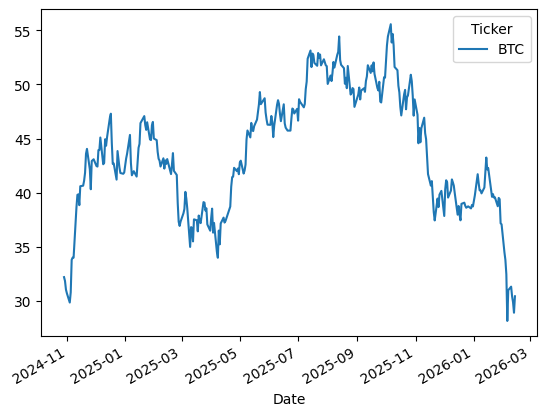

In [29]:
asset_df['Adj Close'].plot()

## Calculate Returns

In [30]:
# Calculate returns
asset_df['return'] = asset_df['Adj Close'].pct_change().dropna()

# Positive returns
asset_df['positive_return'] = asset_df['return'].apply(lambda x: x if x>0 else 0)
asset_df['positive_return_mean'] = asset_df['positive_return'].rolling(window=lookback_days).mean()

# Negative returns
asset_df['negative_return'] = asset_df['return'].apply(lambda x: abs(x) if x<0 else 0)
asset_df['negative_return_mean'] = asset_df['negative_return'].rolling(window=lookback_days).mean()

# Time range of interest
asset_df = asset_df[asset_df.index >= start_date].sort_index(ascending=True)
asset_df.head()

Price,Adj Close,Close,High,Low,Open,Volume,return,positive_return,positive_return_mean,negative_return,negative_return_mean
Ticker,BTC,BTC,BTC,BTC,BTC,BTC,,,,,
Date,,,,,,,,,,,
2024-12-02,42.459999,42.459999,43.250000,41.869999,42.560001,1129300,-0.014621,0.000000,0.022687,0.014621,0.008652
2024-12-03,42.419998,42.419998,42.750000,41.508999,41.790001,662300,-0.000942,0.000000,0.022687,0.000942,0.007553
2024-12-04,43.939999,43.939999,44.049999,41.950001,42.540001,1004900,0.035832,0.035832,0.024316,0.000000,0.007041
2024-12-05,43.939999,43.939999,46.049999,43.415001,45.619999,2164400,0.000000,0.000000,0.024316,0.000000,0.005782
2024-12-06,45.099998,45.099998,45.330002,43.770000,44.099998,1523100,0.026400,0.026400,0.024069,0.000000,0.005782


## Calculate  Relative Strength Index (RSI)
RSI = 100-100/(1+positive_return_mean/negative_return_mean)

In [31]:
asset_df['rsi'] = (100-100/
                   (1+asset_df['positive_return_mean']/asset_df['negative_return_mean']))
asset_df.head()

Price,Adj Close,Close,High,Low,Open,Volume,return,positive_return,positive_return_mean,negative_return,negative_return_mean,rsi
Ticker,BTC,BTC,BTC,BTC,BTC,BTC,,,,,,
Date,,,,,,,,,,,,
2024-12-02,42.459999,42.459999,43.250000,41.869999,42.560001,1129300,-0.014621,0.000000,0.022687,0.014621,0.008652,72.392693
2024-12-03,42.419998,42.419998,42.750000,41.508999,41.790001,662300,-0.000942,0.000000,0.022687,0.000942,0.007553,75.023369
2024-12-04,43.939999,43.939999,44.049999,41.950001,42.540001,1004900,0.035832,0.035832,0.024316,0.000000,0.007041,77.546606
2024-12-05,43.939999,43.939999,46.049999,43.415001,45.619999,2164400,0.000000,0.000000,0.024316,0.000000,0.005782,80.789133
2024-12-06,45.099998,45.099998,45.330002,43.770000,44.099998,1523100,0.026400,0.026400,0.024069,0.000000,0.005782,80.630406


## Generate buy, sell, and hold signal

In [32]:
asset_df.loc[asset_df['rsi'] < 30, 'buy'] = 'yes'
asset_df.loc[asset_df['rsi'] > 30, 'buy'] = 'no'

asset_df.head()

Price,Adj Close,Close,High,Low,Open,Volume,return,positive_return,positive_return_mean,negative_return,negative_return_mean,rsi,buy
Ticker,BTC,BTC,BTC,BTC,BTC,BTC,,,,,,,
Date,,,,,,,,,,,,,
2024-12-02,42.459999,42.459999,43.250000,41.869999,42.560001,1129300,-0.014621,0.000000,0.022687,0.014621,0.008652,72.392693,no
2024-12-03,42.419998,42.419998,42.750000,41.508999,41.790001,662300,-0.000942,0.000000,0.022687,0.000942,0.007553,75.023369,no
2024-12-04,43.939999,43.939999,44.049999,41.950001,42.540001,1004900,0.035832,0.035832,0.024316,0.000000,0.007041,77.546606,no
2024-12-05,43.939999,43.939999,46.049999,43.415001,45.619999,2164400,0.000000,0.000000,0.024316,0.000000,0.005782,80.789133,no
2024-12-06,45.099998,45.099998,45.330002,43.770000,44.099998,1523100,0.026400,0.026400,0.024069,0.000000,0.005782,80.630406,no


In [33]:
buy_dates = []
sell_dates = []
hold_dates = []

for i in range(len(asset_df)):
    if asset_df['buy'].iloc[i] == "yes":
        buy_dates.append(asset_df.iloc[i+1].name)

## Sell Rules
* RSI above 40
* 10 operation days

In [34]:
asset_df['rsi'].iloc[2]

np.float64(77.5466060648187)

In [35]:
buy_dates = []
sell_dates = []
hold_dates = []

# The highest index number we are able to access
max_idx = len(asset_df) - 1

for i in range(len(asset_df)):
    
    if asset_df['buy'].iloc[i] == "yes":

        if i+1 > max_idx: # Check if we can access the next day
            break

        buy_dates.append(asset_df.iloc[i+1].name) # buy the open price on next days

        sold = False

        for j in range(1,11): # 10 days

            if i+j > max_idx: # Check if we can access the next day
                break

            if asset_df['rsi'].iloc[i+j] > 40: # Checking for RSI > 40 in the next 10 days

                if i+j+1 <= max_idx: # Check if we can access the next day
                    sell_dates.append(asset_df.iloc[i+j+1].name) # sell on the next day that hits 40
                    sold = True
                break
            
            elif j==10:
                if i+j+1 <= max_idx: # Check if we can access the next day
                    sell_dates.append(asset_df.iloc[i+j+1].name)    
                    sold = True

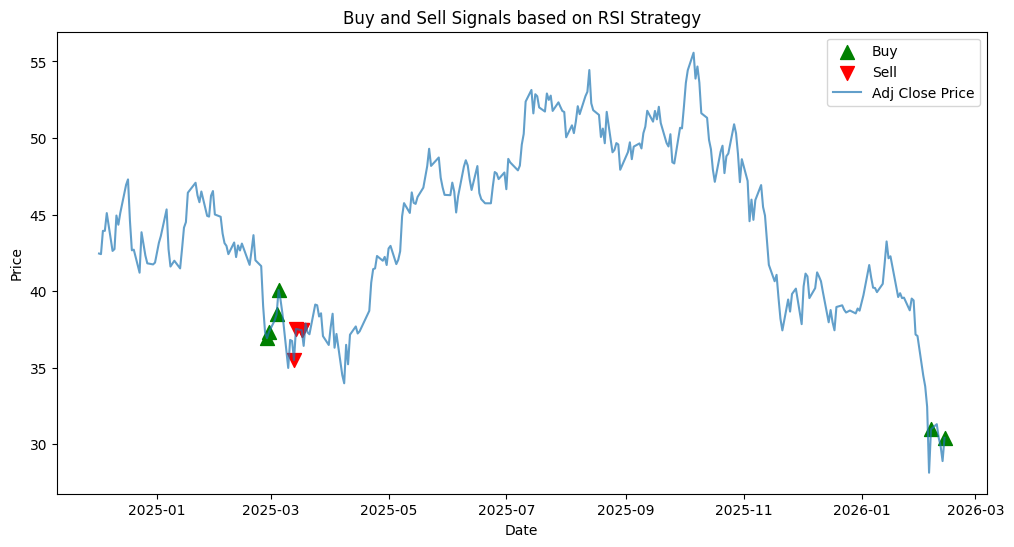

In [36]:
plt.figure(figsize=(12,6))
plt.scatter(buy_dates, asset_df.loc[buy_dates, 'Adj Close'], marker='^', color='g', label='Buy', s=100)
plt.scatter(sell_dates, asset_df.loc[sell_dates, 'Adj Close'], marker='v', color='r', label='Sell', s=100)
plt.plot(asset_df['Adj Close'], label='Adj Close Price', alpha=.7)
plt.title('Buy and Sell Signals based on RSI Strategy')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Compute Profit

In [37]:
# Find out how many full, completed trades we actually have
completed_trades = min(len(buy_dates), len(sell_dates))

if completed_trades == 0:
    print("No completed trades found. Cannot calculate profit.")
else:
    # Slice both lists to only include completed pairs
    # (This drops the recent buys that haven't sold yet)
    matched_buys = buy_dates[:completed_trades]
    matched_sells = sell_dates[:completed_trades]
    
    # Calculate profit safely
    buy_prices = asset_df.loc[matched_buys, 'Open'].values
    sell_prices = asset_df.loc[matched_sells, 'Open'].values
    
    profit = (sell_prices / buy_prices) - 1
    
    print("Trade Profits:", profit)

Trade Profits: [[-0.03872317]
 [ 0.01875863]
 [ 0.00259177]
 [-0.07640113]]


## Engine Analysis

Win Rate: 50.00%
Average Profit on Winning Trades: 1.07%
Average Loss on Losing Trades: 5.76%
Mathematical Expectation per Trade: -2.34%
Total Return over 4 Trades: -9.32%


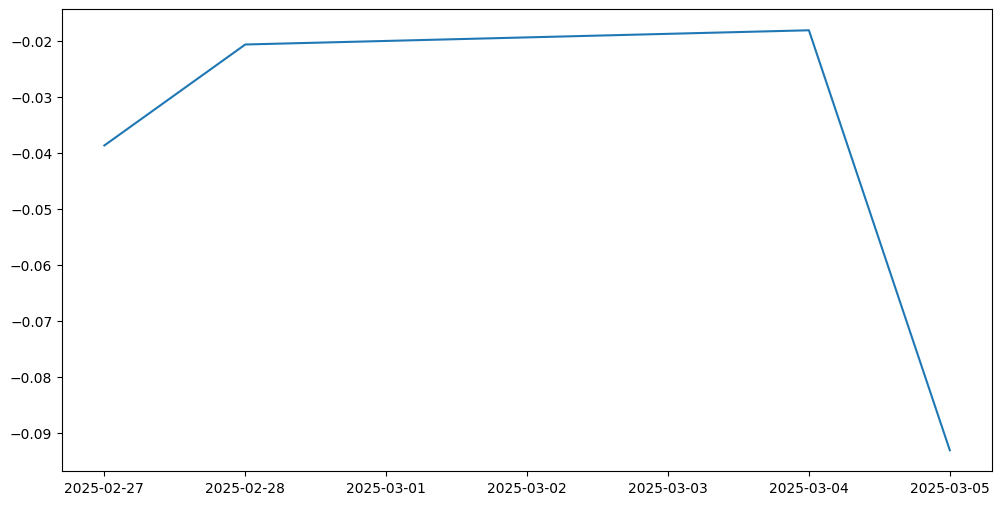

In [44]:
win_rate = (profit > 0).sum() / len(profit)
print(f"Win Rate: {win_rate:.2%}")

profit_mean = np.mean(profit[profit > 0])
loss_mean = abs(np.mean(profit[profit < 0]))
print(f"Average Profit on Winning Trades: {profit_mean:.2%}")
print(f"Average Loss on Losing Trades: {loss_mean:.2%}")

model_math_expectation = (win_rate * profit_mean) - ((1 - win_rate) * loss_mean)
print(f"Mathematical Expectation per Trade: {model_math_expectation:.2%}")

acumulated_performance = np.cumprod(1 + profit) - 1
print(f"Total Return over {completed_trades} Trades: {acumulated_performance[-1]:.2%}")

plt.figure(figsize=(12,6))
plt.plot(matched_buys, acumulated_performance)

## Evaluate Buy and Hold

In [53]:
buy_and_hold_performance = (asset_df['Adj Close'].iloc[-1]/ asset_df['Adj Close'].iloc[0] - 1).item()
print(f"Buy and Hold Performance: {buy_and_hold_performance:.2%}")

Buy and Hold Performance: -28.33%
